# Create meta-fields

In [1]:
# Fields accessible to use in rationalization?
# ... some of which are VERY unfair
accessible_fields = [
    # 'sex', # >:(
    # 'race', # >:(
    'age',
    'age_cat',
    'juv_fel_count',
    'decile_score',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
]
# Field we are trying to rationalize why it could be 1 vs 0
justifying_field = 'is_recid' # 'is_recid' or 'is_violent_recid'
# Field that is the actual data for what we are trying to determine
trueresult_field = 'two_year_recid'
# Field that is 1 if justifying==trueresult, otherwise 0
wascorrect_field = 'pred_accurate'

# Threshold for confidence range
conf_alpha = 0.05

# Seed for 'train'/'test' split sampling
sampling_seed = 1
# Maximum number of factors to include in the whole-dataset evaluation
max_ratexpl_factors = 2

# Handle dataset

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## Import COMPAS dataset

In [3]:
# Import dataset
raw_data_df = pd.read_csv("data-compas/compas-scores-two-years.csv")
raw_data_df.shape

(7214, 53)

In [4]:
raw_data_df[:5]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Filter dataset similar to ProPublica's method

In [5]:
# see: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
filter_data_df = raw_data_df
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] >= -30]
filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] <= 30]
filter_data_df = filter_data_df[filter_data_df['is_recid'] != -1]
filter_data_df = filter_data_df[filter_data_df['c_charge_degree'] != 'O']
filter_data_df = filter_data_df[filter_data_df['score_text'] != 'N/A']
filter_data_df.shape

(6172, 53)

## Create a "prediction was correct" column

In [6]:
filter_data_df[wascorrect_field] = filter_data_df.apply(
    lambda r: 1 if r[justifying_field]==r[trueresult_field] else 0, 
    axis='columns'
)

## Split data into "training", "test"

In [7]:
split_ratio = 0.8

filter_data_df_src = filter_data_df.sample(n=int(split_ratio*len(filter_data_df)), random_state=sampling_seed)
filter_data_df_test = filter_data_df[~filter_data_df.index.isin(filter_data_df_src.index)]

print(filter_data_df_src.shape)
print(filter_data_df_test.shape)

(4937, 54)
(1235, 54)


# Define rationalization

In [8]:
from statsmodels.stats import proportion

def rationalize(target, data_df, numfields=1):
    def noIntervalOverlap(a1, a2, b1, b2):
        if a1>a2 or b1>b2:
            raise ValueError('unexpected bounds')
        if a2<b1 and a1<b1:
            return True
        if b2<a1 and b1<a1:
            return True
        return False
    breakdown = data_df[trueresult_field]
    full_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
    result_df = pd.DataFrame()
    field_groups = [[i] for i in range(len(accessible_fields))]
    for _ in range(numfields-1):
        field_groups = [[f+[i] for i in range(len(accessible_fields)) if i>f[-1]] for f in field_groups]
        field_groups = [e for l in field_groups for e in l]
    for field_ids in field_groups:
        field_names = [accessible_fields[i] for i in field_ids]
        subgroup = data_df
        for field in field_names:
            subgroup = subgroup[subgroup[field] == target[field]]
        subgroup_inv = data_df[~data_df.index.isin(subgroup.index)]
        breakdown = subgroup[trueresult_field]
        breakdown_inv = subgroup_inv[trueresult_field]
        preds = subgroup[justifying_field]
        preds_inv = subgroup_inv[justifying_field]
        corrects = subgroup[wascorrect_field]
        corrects_inv = subgroup_inv[wascorrect_field]
        if len(breakdown)>0:
            conf_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
            invg_interval = proportion.proportion_confint(sum(breakdown_inv), len(breakdown_inv), alpha=conf_alpha, method='beta')
            result_df = result_df.append({
                'id': target['id'],
                'field_count': len(field_names),
                'fields': field_names,
                'fields_key': (tuple(field_names), tuple([target[fn] for fn in field_names])),
                'sample_size': len(breakdown),
                f'{trueresult_field}_mean': sum(breakdown) / len(breakdown),
                f'{justifying_field}_mean': sum(preds) / len(preds),
                f'accuracy_mean': sum(corrects) / len(corrects),
                # Confidence interval: in 95% of cases, the true underlying fraction of recidivism will fall within this interval
                # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
                # https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportion_confint.html
                f'{trueresult_field}_conf_bot': conf_interval[0],
                f'{trueresult_field}_conf_top': conf_interval[1],
                # Statistical significance
                'significant_baseline': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], full_interval[0], full_interval[1]) else 0,
                # Okay, now... all of this again for the inverse group
                # Results for the inverse group
                f'{trueresult_field}_inv_mean': sum(breakdown_inv) / len(breakdown_inv),
                f'{justifying_field}_inv_mean': sum(preds_inv) / len(preds_inv),
                f'accuracy_inv_mean': sum(corrects_inv) / len(corrects_inv),
                'significant_invgroup': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], invg_interval[0], invg_interval[1]) else 0,
            }, ignore_index=True)
    return result_df

In [9]:
breakdown = filter_data_df_src[trueresult_field]
print('true recidivism (training):', sum(breakdown)/len(breakdown))
print('true recidivism (training) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta'))

print()

breakdown = filter_data_df_test[trueresult_field]
print('true recidivism (testing):', sum(breakdown)/len(breakdown))
print('true recidivism (testing) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta'))

true recidivism (training): 0.45716021875632973
true recidivism (training) range: (0.44319184736754513, 0.4711792887904168)

true recidivism (testing): 0.44696356275303645
true recidivism (testing) range: (0.4189846057985733, 0.4751955907516002)


In [10]:
# Mini-example of selecting someone to justify both-sides of
target = filter_data_df[filter_data_df['id'] == 2680].iloc[0] # filter_data_df.sample(n=1).iloc[0]
filter_data_df[filter_data_df['id'] == target['id']]

rationalize_df = pd.DataFrame()
for numfields in [1,2,3]:
    rationalize_df = rationalize_df.append(
        rationalize(target, filter_data_df_src, numfields=numfields),
        ignore_index=True
    )

# rationalize_df.sort_values(['significant_baseline', f'{trueresult_field}_mean'])
rationalize_df[rationalize_df['significant_baseline'] == 1].sort_values(f'{trueresult_field}_mean')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,pred_accurate
1766,2680,jazze johnson,jazze,johnson,2013-05-14,Male,1986-09-29,29,25 - 45,African-American,0,8,0,0,0,-1.0,2013-05-13 07:26:35,2013-05-16 03:43:24,13006827CF10A,2013-05-13,NaN,1.0,F,Poss of Cocaine W/I/D/S 1000FT Park,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-05-14,Risk of Violence,4,Low,2013-05-14,2015-05-04,2015-08-19,0,2,720,0,0,1


,id,field_count,fields,fields_key,sample_size,two_year_recid_mean,is_recid_mean,accuracy_mean,two_year_recid_conf_bot,two_year_recid_conf_top,significant_baseline,two_year_recid_inv_mean,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup
70,2680.0,3.0,"[age, priors_count, c_charge_degree]","((age, priors_count, c_charge_degree), (29, 0,...",34.0,0.235294,0.235294,1.000000,0.107462,0.411708,1.0,0.458699,0.486233,0.972466,1.0
21,2680.0,2.0,"[age_cat, priors_count]","((age_cat, priors_count), (25 - 45, 0))",825.0,0.250909,0.265455,0.985455,0.221653,0.281956,1.0,0.498541,0.528453,0.970088,1.0
85,2680.0,3.0,"[age_cat, juv_misd_count, priors_count]","((age_cat, juv_misd_count, priors_count), (25 ...",825.0,0.250909,0.265455,0.985455,0.221653,0.281956,1.0,0.498541,0.528453,0.970088,1.0
76,2680.0,3.0,"[age_cat, juv_fel_count, priors_count]","((age_cat, juv_fel_count, priors_count), (25 -...",825.0,0.250909,0.265455,0.985455,0.221653,0.281956,1.0,0.498541,0.528453,0.970088,1.0
88,2680.0,3.0,"[age_cat, juv_other_count, priors_count]","((age_cat, juv_other_count, priors_count), (25...",817.0,0.253366,0.268054,0.985312,0.223864,0.284659,1.0,0.497573,0.527427,0.970146,1.0
91,2680.0,3.0,"[age_cat, priors_count, c_charge_degree]","((age_cat, priors_count, c_charge_degree), (25...",430.0,0.262791,0.269767,0.993023,0.221782,0.307098,1.0,0.475704,0.504992,0.970712,1.0
55,2680.0,3.0,"[age, juv_fel_count, priors_count]","((age, juv_fel_count, priors_count), (29, 0, 0))",63.0,0.269841,0.269841,1.000000,0.165713,0.396515,1.0,0.459581,0.487279,0.972302,1.0
14,2680.0,2.0,"[age, priors_count]","((age, priors_count), (29, 0))",63.0,0.269841,0.269841,1.000000,0.165713,0.396515,1.0,0.459581,0.487279,0.972302,1.0
67,2680.0,3.0,"[age, juv_other_count, priors_count]","((age, juv_other_count, priors_count), (29, 0,...",63.0,0.269841,0.269841,1.000000,0.165713,0.396515,1.0,0.459581,0.487279,0.972302,1.0
64,2680.0,3.0,"[age, juv_misd_count, priors_count]","((age, juv_misd_count, priors_count), (29, 0, 0))",63.0,0.269841,0.269841,1.000000,0.165713,0.396515,1.0,0.459581,0.487279,0.972302,1.0


# Visualize small sample of rationalization bounds

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def vis(filter_data_df_src, filter_data_df_test, count_bothsides, count_factors):
    plt.rcParams['figure.figsize'] = [15, 5]
    gap_size = 10
    
    # Randomly select someone to justify negative pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 0].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n) for i in rationalize_df['field_count']],
            rationalize_df[f'{trueresult_field}_mean'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            range_lo = min(temp_df[f'{trueresult_field}_conf_top'])
            range_hi = max(temp_df[f'{trueresult_field}_conf_bot'])
            pos_x = (2*i)+(2*count_factors*n)+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )

    # Randomly select someone to justify positive pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[justifying_field] == 1].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size for i in rationalize_df['field_count']], 
            rationalize_df[f'{trueresult_field}_mean'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            if len(temp_df)==0:
                pass
            if len(temp_df[f'{trueresult_field}_conf_top'])==0:
                print(temp_df)
                raise ValueError()
            range_lo = min(temp_df[f'{trueresult_field}_conf_top'])
            if len(temp_df[f'{trueresult_field}_conf_bot'])==0:
                print(temp_df)
                raise ValueError()
            range_hi = max(temp_df[f'{trueresult_field}_conf_bot'])
            pos_x = (2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size+1
            marker = 'o' if (range_lo<=range_hi) else ''
            _ = plt.plot(
                [pos_x,pos_x], 
                [range_lo,range_hi],
                color=dots.get_facecolors()[0][:-1],
                marker=marker,
            )
    
    # population mean line
    breakdown = filter_data_df_src[trueresult_field]
    src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
    plt.axline((1, sum(breakdown)/len(breakdown)), slope=0, alpha=0.4)
    plt.fill_between(
        [0, 4*count_factors*count_bothsides+gap_size+2], 
        [src_range[1], src_range[1]], 
        [src_range[0], src_range[0]], 
        alpha=0.2
    )
    # 50% line
    plt.axline((1, 0.5), slope=0, alpha=0.8)
    plt.show()

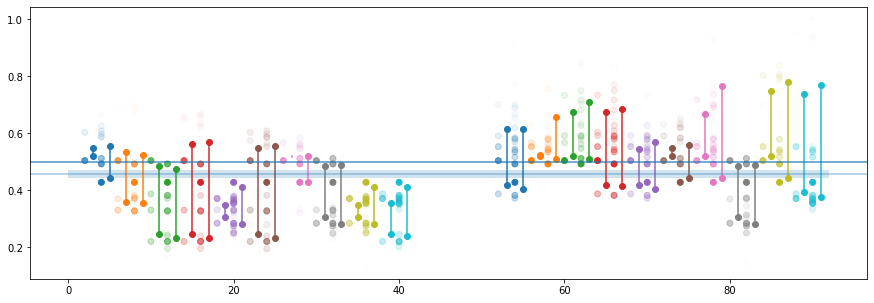

In [12]:
vis(filter_data_df_src, filter_data_df_test, 10, 2)

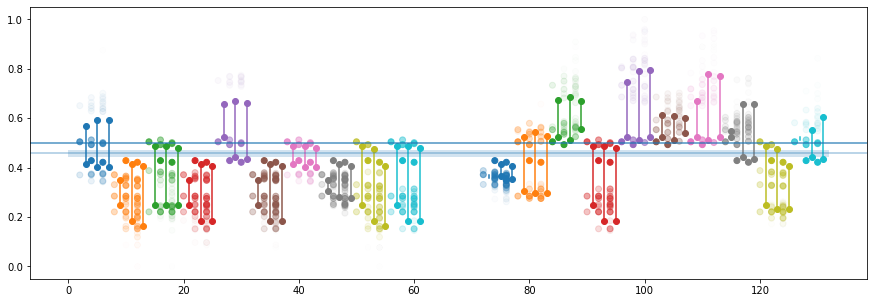

In [13]:
vis(filter_data_df_src, filter_data_df_test, 10, 3)

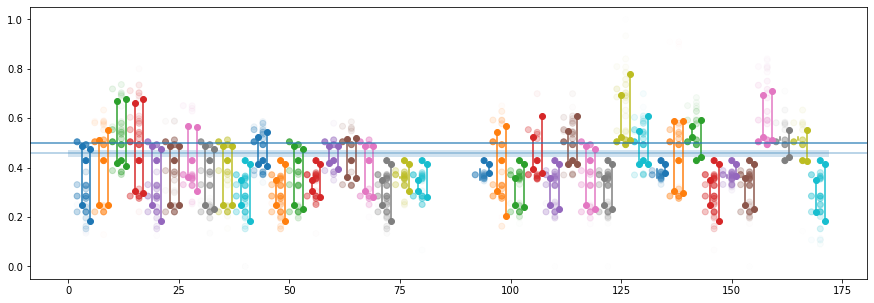

In [14]:
vis(filter_data_df_src, filter_data_df_test, 20, 2)

In [15]:
# vis(filter_data_df_src, filter_data_df_test, 20, 3)

In [16]:
# vis(filter_data_df_src, filter_data_df_test, 20, 4)

# Calculate rationalization for ALL test set samples

In [17]:
# Calculate rationalization for all test set samples
# Backup this rationalization in the file with title format f'temp-export/'

from os.path import exists
backup_path = f'temp-export/COMPAS_RAT_F{justifying_field}_T{trueresult_field}_C{conf_alpha}_NF{max_ratexpl_factors}_S{sampling_seed}.pkl'

# if backup doesn't exist, make it
if not exists(backup_path):
    test_rationalizations = pd.DataFrame()
    for _, case in filter_data_df_test.iterrows():
        for numfields in range(1, max_ratexpl_factors+1):
            test_rationalizations = pd.concat(
                [
                    test_rationalizations,
                    rationalize(case, filter_data_df_src, numfields=numfields),
                ],
                ignore_index=True,
            )
    test_rationalizations.to_pickle(backup_path)
# load from the backup
test_rationalizations = pd.read_pickle(backup_path)

# Add column representing the 'side' that each rationalization is in favor of
breakdown = filter_data_df_src[trueresult_field]
justifying_ref_avg = sum(breakdown)/len(breakdown)
test_rationalizations[f'{justifying_field}_rat_side'] = test_rationalizations.apply(lambda r: 1 if r[f'{trueresult_field}_mean']>justifying_ref_avg else 0, axis=1)

In [18]:
test_rationalizations[:2]

,id,field_count,fields,fields_key,sample_size,two_year_recid_mean,is_recid_mean,accuracy_mean,two_year_recid_conf_bot,two_year_recid_conf_top,significant_baseline,two_year_recid_inv_mean,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup,is_recid_rat_side
0,4.0,1.0,[age],"((age,), (24,))",251.0,0.482072,0.505976,0.976096,0.418797,0.545774,0.0,0.455826,0.483355,0.972471,0.0,1
1,4.0,1.0,[age_cat],"((age_cat,), (Less than 25,))",1082.0,0.553604,0.578558,0.975046,0.523410,0.583507,1.0,0.430091,0.458106,0.971984,1.0,1


In [19]:
# Calculate confidence interval of entire training dataset
breakdown = filter_data_df_src[trueresult_field]
src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=conf_alpha, method='beta')
src_range

(0.44319184736754513, 0.4711792887904168)

# Visualize all test-set results?

## Show distribution of confidence interval gaps

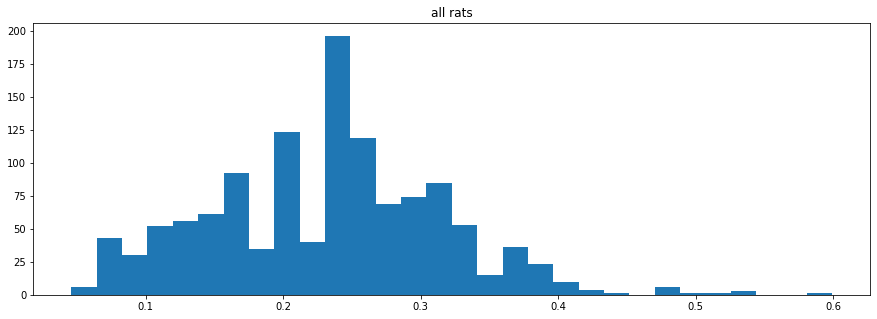

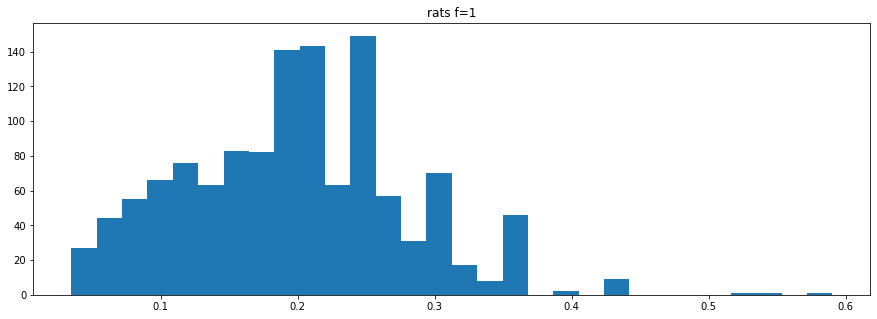

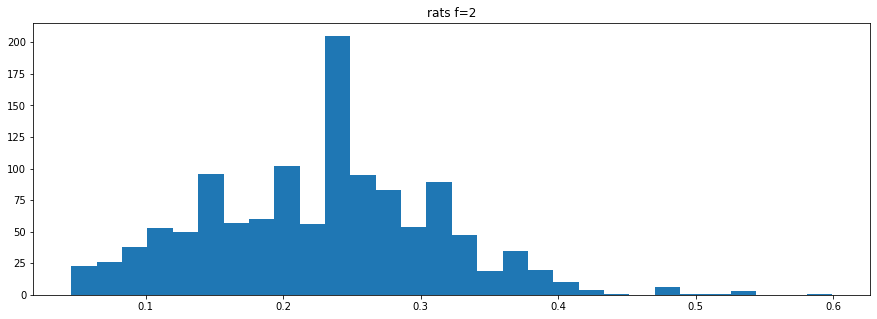

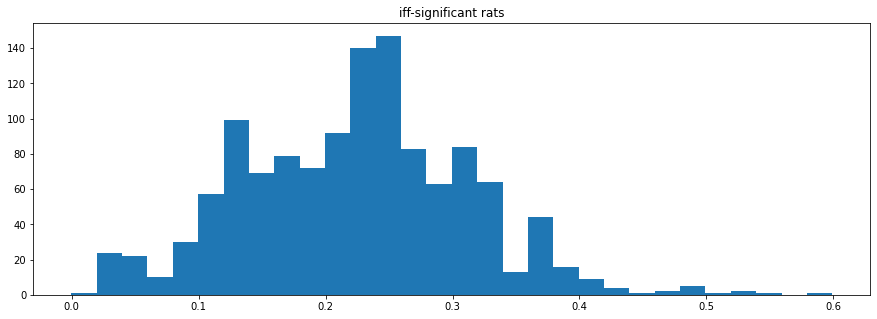

In [20]:
import matplotlib.pyplot as plt
import numpy as np

num_bins = 30

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0"
# (negative value means no gap, they overlap)
temp_gaps = []
for x_id, x_rat in test_rationalizations.groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('all rats')
plt.show()

# CI gaps ... for size-1 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations[test_rationalizations['field_count']==1].groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('rats f=1')
plt.show()

# CI gaps ... for size-2 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations[test_rationalizations['field_count']==2].groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('rats f=2')
plt.show()

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0" for ONLY the significant sets
test_signif_rat = test_rationalizations[test_rationalizations['significant_baseline']==1]
temp_gaps = []
for x_id, x_rat in test_signif_rat.groupby(['id']):
    range_lo = min(x_rat[f'{trueresult_field}_conf_top'])
    range_hi = max(x_rat[f'{trueresult_field}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('iff-significant rats')
plt.show() 

## Show frequency of single-rat and double-rat cases

In [21]:
tags = {'id':[], 'rat_goal':[], 'ratted_single':[], 'ratted_double':[]}
for x_id, x_rat in test_rationalizations[test_rationalizations['significant_baseline'] == 1].groupby(['id']):
    tags['id'].append(x_id)
    x_goal = filter_data_df_test[filter_data_df_test['id']==x_id].iloc[0][justifying_field]
    tags['rat_goal'].append(x_goal)
    # figure out if goal has been achieved to prediction case-by-case
    tags['ratted_single'].append(any(x_rat[f'{justifying_field}_rat_side']==x_goal))
    # figure out if goal could be achievable either way case-by-case
    rat_total = sum(x_rat[f'{justifying_field}_rat_side'])
    tags['ratted_double'].append(rat_total<len(x_rat[f'{justifying_field}_rat_side']) and rat_total>0)
test_ratsides = pd.DataFrame(tags)
test_ratsides[:5]

,id,rat_goal,ratted_single,ratted_double
0,4.0,1,True,False
1,22.0,0,True,True
2,23.0,1,True,True
3,26.0,1,True,True
4,28.0,0,True,True


In [22]:
print('successful rat single', sum(test_ratsides['ratted_single'])/len(test_ratsides))
print('successful rat double', sum(test_ratsides['ratted_double'])/len(test_ratsides))

successful rat single 0.940080971659919
successful rat double 0.7538461538461538


In [23]:
# for all cases, show distribution of 2-rat (could support both), exclusive-pro-rat (only for preds), and exclusive-non-rat (against preds)
temp_counts = {}
for x_id, x_rat in test_rationalizations[test_rationalizations['significant_baseline'] == 1].groupby(['id']):
    x_ratted = test_ratsides[test_ratsides['id']==x_id].iloc[0]
    if x_ratted['rat_goal'] not in temp_counts:
        # Initialize empty entry
        temp_counts[x_ratted['rat_goal']] = {
            '2rat': 0,
            'xprorat': 0,
            'xnonrat': 0,
        }
    if x_ratted['ratted_double']:
        temp_counts[x_ratted['rat_goal']]['2rat'] += 1
    elif x_ratted['ratted_single']:
        temp_counts[x_ratted['rat_goal']]['xprorat'] += 1
    else:
        temp_counts[x_ratted['rat_goal']]['xnonrat'] += 1

temp_counts

{1: {'2rat': 465, 'xprorat': 68, 'xnonrat': 65},
 0: {'2rat': 466, 'xprorat': 162, 'xnonrat': 9}}

# Do group multi-element rationalizing

In [24]:
# TODO do simple mass group rationalizing using the entire test set, maximizing what we can justify within the entire test set

In [25]:
# TODO do "trained" mass group rationalizing using the entire training set, maximizing what within the training set we can justify and applying it to the test set as a whole

In [26]:
# TODO do one-by-one rationalizing by going through the test set in order, selecting a justification for each and minimizing future conflict (greedy approach)

In [27]:
# Pick out every distinct set of field-value examinations that could be used for justification
fields_keys_gb = test_rationalizations[test_rationalizations['significant_baseline']==1].merge(
    filter_data_df_test[['id', justifying_field, trueresult_field]], left_on='id', right_on='id'
).groupby(
    by=['fields_key']
)

In [28]:
# Determine if a field key (set of fields and values) applies to a given dataset row
def key_applicable(row, field_key):
    for i in range(len(field_key[0])):
        fname = field_key[0][i]
        fval = field_key[1][i]
        if row[fname]!=fval:
            return False
    return True
    
# Pick out examples from a given dataset that could apply to each field-key
def identify_examples(data_df, fields_keys_gb):
    fields_keys_relevantsrc = pd.DataFrame()
    for k in fields_keys_gb.groups.keys():
        subset = data_df[
            data_df.apply(lambda r: key_applicable(r,k), axis='columns')
        ][['id', justifying_field, trueresult_field]]
        subset['fields_key'] = [k for _ in range(len(subset))]
        fields_keys_relevantsrc = fields_keys_relevantsrc.append(subset)
    fields_keys_relevantsrc_gb = fields_keys_relevantsrc.groupby(by=['fields_key'])
    return fields_keys_relevantsrc_gb

fields_keys_relevantsrc_gb = identify_examples(filter_data_df_src, fields_keys_gb)

In [29]:
fields_keys = pd.DataFrame()
fields_keys[f'{justifying_field}_rat_side'] = fields_keys_gb.apply(
    lambda x: x[f'{justifying_field}_rat_side'].mean()
)
# Add train set stats
fields_keys[f'src_{justifying_field}_mean'] = fields_keys_relevantsrc_gb.apply(
    lambda x: x[justifying_field].mean()
)
fields_keys[f'src_{trueresult_field}_mean'] = fields_keys_relevantsrc_gb.apply(
    lambda x: x[trueresult_field].mean()
)
fields_keys['src_samples'] = fields_keys_relevantsrc_gb.apply(
    lambda x: len(x)
)
fields_keys['src_id_samples'] = fields_keys_relevantsrc_gb.apply(
    lambda x: list(x['id'])
)
# Add test set stats
fields_keys[f'test_{justifying_field}_mean'] = fields_keys_gb.apply(
    lambda x: x[justifying_field].mean()
)
fields_keys[f'test_{trueresult_field}_mean'] = fields_keys_gb.apply(
    lambda x: x[trueresult_field].mean()
)
fields_keys['test_samples'] = fields_keys_gb.apply(
    lambda x: len(x)
)
fields_keys['test_id_samples'] = fields_keys_gb.apply(
    lambda x: list(x['id'])
)
fields_keys = fields_keys.reset_index(level=0)
fields_keys[:5]#.sort_values('test_samples').sort_values(f'test_{justifying_field}_mean')

,fields_key,is_recid_rat_side,src_is_recid_mean,src_two_year_recid_mean,src_samples,src_id_samples,test_is_recid_mean,test_two_year_recid_mean,test_samples,test_id_samples
0,"((age,), (19,))",1.0,1.000000,0.947368,19,"[659, 9752, 6044, 5263, 2228, 8403, 7429, 1345...",1.000000,1.000000,7,"[151.0, 3691.0, 3929.0, 4127.0, 4971.0, 5383.0..."
1,"((age,), (20,))",1.0,0.716418,0.701493,134,"[904, 1951, 9030, 10007, 7098, 7591, 7493, 205...",0.785714,0.750000,28,"[469.0, 480.0, 1143.0, 1209.0, 1439.0, 2129.0,..."
2,"((age,), (21,))",1.0,0.608696,0.565217,230,"[6815, 9488, 139, 1151, 1283, 4282, 1253, 7285...",0.589286,0.571429,56,"[26.0, 28.0, 446.0, 738.0, 830.0, 1093.0, 1282..."
3,"((age,), (22,))",1.0,0.565421,0.546729,214,"[9773, 4179, 977, 408, 4368, 1027, 10119, 9039...",0.620690,0.534483,58,"[102.0, 275.0, 579.0, 604.0, 852.0, 930.0, 179..."
4,"((age,), (27,))",1.0,0.584821,0.549107,224,"[10195, 9277, 8925, 998, 4961, 4385, 8814, 102...",0.629630,0.629630,54,"[90.0, 184.0, 229.0, 597.0, 688.0, 901.0, 1065..."


In [30]:
test_rationalizations[:5]

temp_singlemerge = test_rationalizations.merge(filter_data_df_test[['id', justifying_field]], left_on='id', right_on='id')
temp_singlemerge[:5]

,id,field_count,fields,fields_key,sample_size,two_year_recid_mean,is_recid_mean,accuracy_mean,two_year_recid_conf_bot,two_year_recid_conf_top,significant_baseline,two_year_recid_inv_mean,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup,is_recid_rat_side
0,4.0,1.0,[age],"((age,), (24,))",251.0,0.482072,0.505976,0.976096,0.418797,0.545774,0.0,0.455826,0.483355,0.972471,0.0,1
1,4.0,1.0,[age_cat],"((age_cat,), (Less than 25,))",1082.0,0.553604,0.578558,0.975046,0.523410,0.583507,1.0,0.430091,0.458106,0.971984,1.0,1
2,4.0,1.0,[juv_fel_count],"((juv_fel_count,), (0,))",4760.0,0.447059,0.473319,0.973739,0.432866,0.461317,0.0,0.728814,0.785311,0.943503,1.0,0
3,4.0,1.0,[decile_score],"((decile_score,), (4,))",524.0,0.433206,0.463740,0.969466,0.390306,0.476864,0.0,0.460005,0.486970,0.973034,0.0,0
4,4.0,1.0,[juv_misd_count],"((juv_misd_count,), (0,))",4664.0,0.442110,0.468696,0.973413,0.427790,0.456503,0.0,0.714286,0.754579,0.959707,1.0,0


,id,field_count,fields,fields_key,sample_size,two_year_recid_mean,is_recid_mean,accuracy_mean,two_year_recid_conf_bot,two_year_recid_conf_top,significant_baseline,two_year_recid_inv_mean,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup,is_recid_rat_side,is_recid
0,4.0,1.0,[age],"((age,), (24,))",251.0,0.482072,0.505976,0.976096,0.418797,0.545774,0.0,0.455826,0.483355,0.972471,0.0,1,1
1,4.0,1.0,[age_cat],"((age_cat,), (Less than 25,))",1082.0,0.553604,0.578558,0.975046,0.523410,0.583507,1.0,0.430091,0.458106,0.971984,1.0,1,1
2,4.0,1.0,[juv_fel_count],"((juv_fel_count,), (0,))",4760.0,0.447059,0.473319,0.973739,0.432866,0.461317,0.0,0.728814,0.785311,0.943503,1.0,0,1
3,4.0,1.0,[decile_score],"((decile_score,), (4,))",524.0,0.433206,0.463740,0.969466,0.390306,0.476864,0.0,0.460005,0.486970,0.973034,0.0,0,1
4,4.0,1.0,[juv_misd_count],"((juv_misd_count,), (0,))",4664.0,0.442110,0.468696,0.973413,0.427790,0.456503,0.0,0.714286,0.754579,0.959707,1.0,0,1
